In [7]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import torch
from medmnist import OrganMNIST3D, NoduleMNIST3D, AdrenalMNIST3D, VesselMNIST3D
from utils.visualization import visualize_3d_sample
from utils.data_loader import get_medmnist_dataloaders, HierarchicalMedMNISTDataset, Augmentation3D
from config import ORGAN_CLASSES, ORGAN_TO_REGION, DEVICE, AUGMENTATION_CONFIG

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {DEVICE}")

PyTorch version: 2.4.1+cu121
Device: cuda


In [8]:
# Load OrganMNIST3D dataset
train_loader, val_loader, test_loader, num_classes = get_medmnist_dataloaders(
    dataset_name='organ',
    batch_size=32,
    num_workers=4
)

print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Number of classes: 11
Training samples: 971
Validation samples: 161
Test samples: 610


Batch shape: torch.Size([32, 1, 28, 28, 28])
Labels shape: torch.Size([32, 1])

Sample 0:
  Label: 0 - bladder
  Region: abdomen


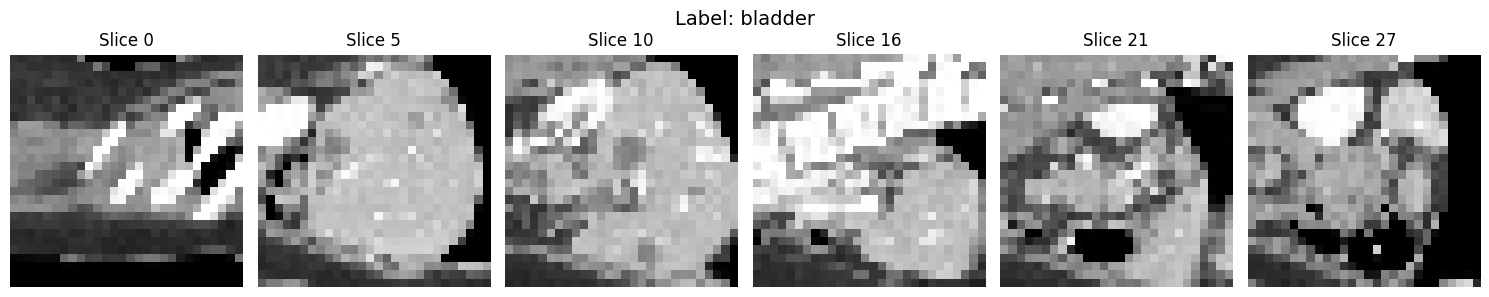

In [9]:
# Get a batch of images
images, labels = next(iter(train_loader))

print(f"Batch shape: {images.shape}")  
print(f"Labels shape: {labels.shape}")

# Visualize first sample
sample_idx = 0
sample_img = images[sample_idx]
sample_label = labels[sample_idx].item()

print(f"\nSample {sample_idx}:")
print(f"  Label: {sample_label} - {ORGAN_CLASSES[sample_label]}")
print(f"  Region: {ORGAN_TO_REGION[ORGAN_CLASSES[sample_label]]}")

visualize_3d_sample(sample_img, label=ORGAN_CLASSES[sample_label])

Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz


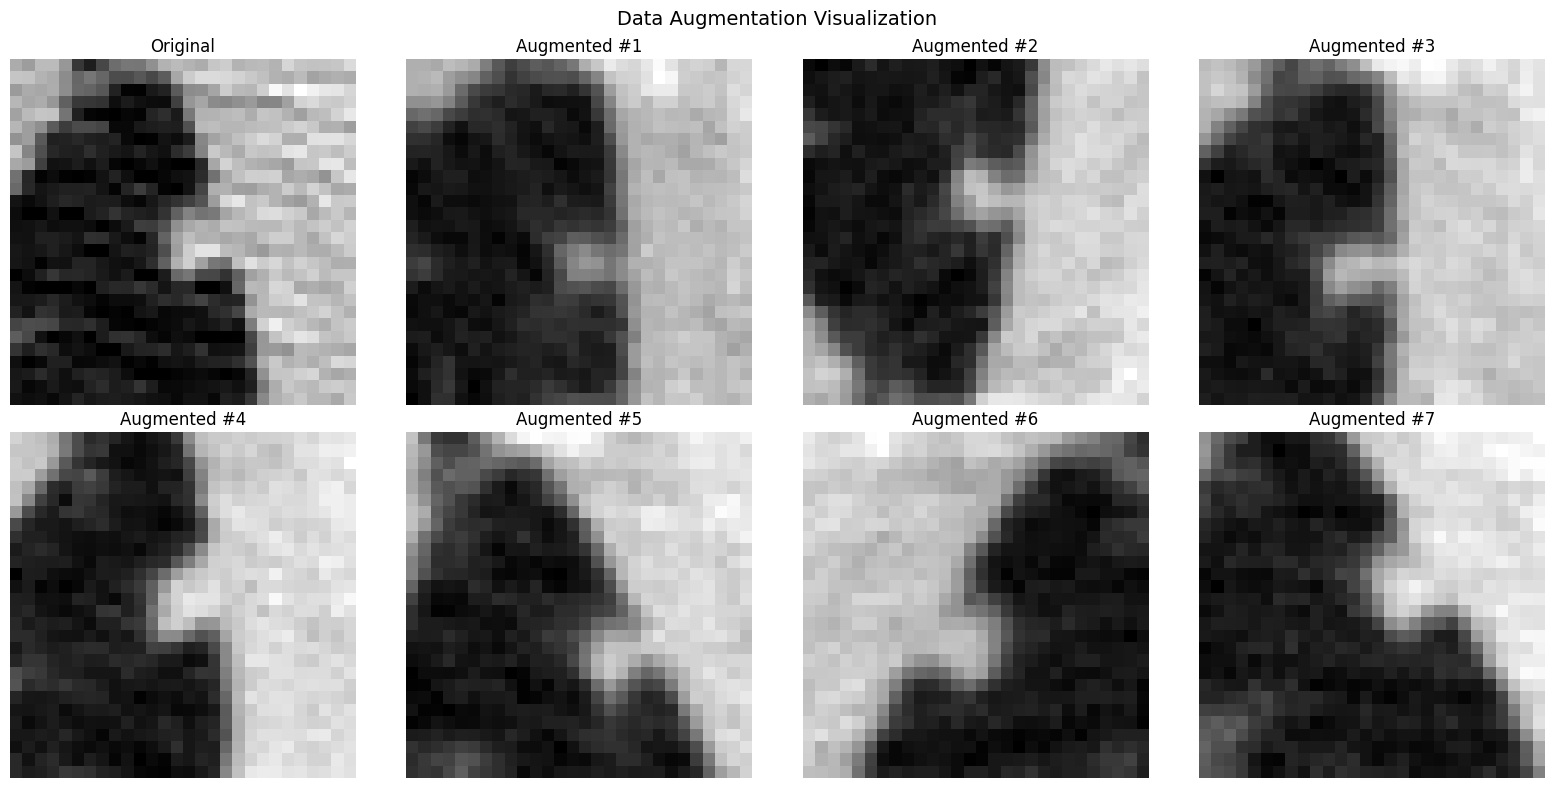

In [ ]:
# Data Augmentation Visualization
# Load dataset WITHOUT augmentation to get original samples
dataset_no_aug = HierarchicalMedMNISTDataset(
    {'nodule': True}, 
    split='train', 
    augment=False
)
# Create augmenter
augmenter = Augmentation3D(AUGMENTATION_CONFIG)
# Pick a sample
sample_idx = 0
original_img = dataset_no_aug.samples[sample_idx].copy()
if original_img.max() > 1:
    original_img = original_img / 255.0
# Generate multiple augmented versions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
# Show original (middle slice)
mid_slice = original_img.shape[1] // 2  # Assuming shape is (C, D, H, W)
axes[0, 0].imshow(original_img[0, mid_slice], cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')
# Show 7 augmented versions
for i in range(7):
    row, col = divmod(i + 1, 4)
    augmented = augmenter(original_img.copy())
    axes[row, col].imshow(augmented[0, mid_slice], cmap='gray')
    axes[row, col].set_title(f'Augmented #{i+1}')
    axes[row, col].axis('off')
plt.suptitle('Data Augmentation Visualization', fontsize=14)
plt.tight_layout()
plt.show()


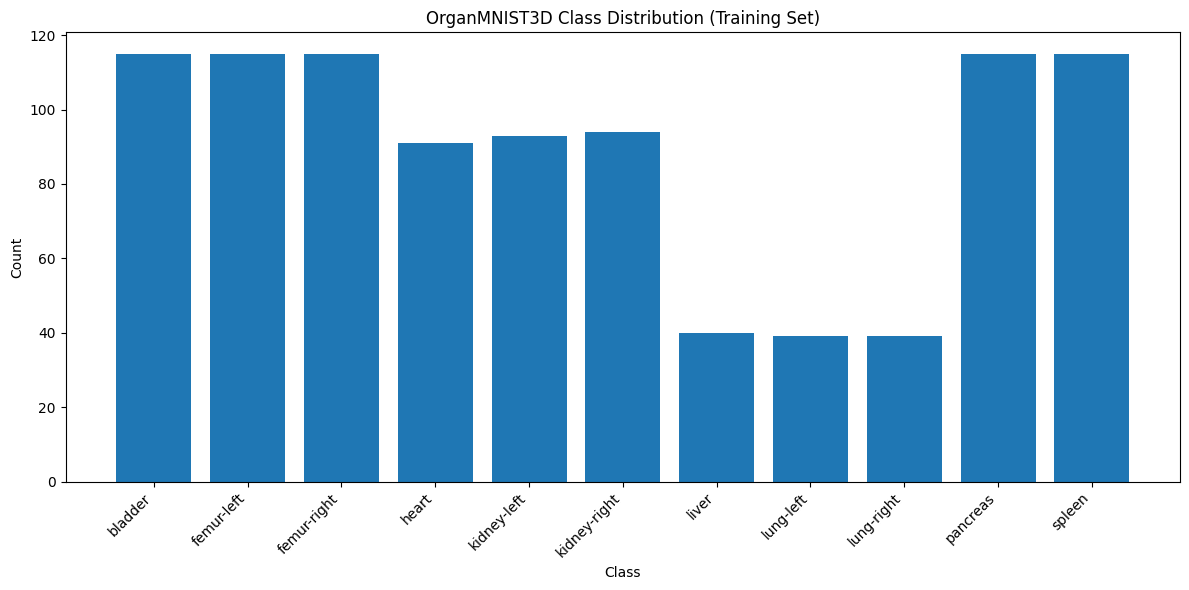


Class distribution:
  bladder: 115 (11.8%)
  femur-left: 115 (11.8%)
  femur-right: 115 (11.8%)
  heart: 91 (9.4%)
  kidney-left: 93 (9.6%)
  kidney-right: 94 (9.7%)
  liver: 40 (4.1%)
  lung-left: 39 (4.0%)
  lung-right: 39 (4.0%)
  pancreas: 115 (11.8%)
  spleen: 115 (11.8%)


In [12]:
# Analyze class distribution
train_dataset = train_loader.dataset
all_labels = train_dataset.labels.squeeze()

unique, counts = np.unique(all_labels, return_counts=True)

# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(unique, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('OrganMNIST3D Class Distribution (Training Set)')
plt.xticks(unique, [ORGAN_CLASSES[i] for i in unique], rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nClass distribution:")
for cls_idx, count in zip(unique, counts):
    print(f"  {ORGAN_CLASSES[cls_idx]}: {count} ({count/len(all_labels)*100:.1f}%)")

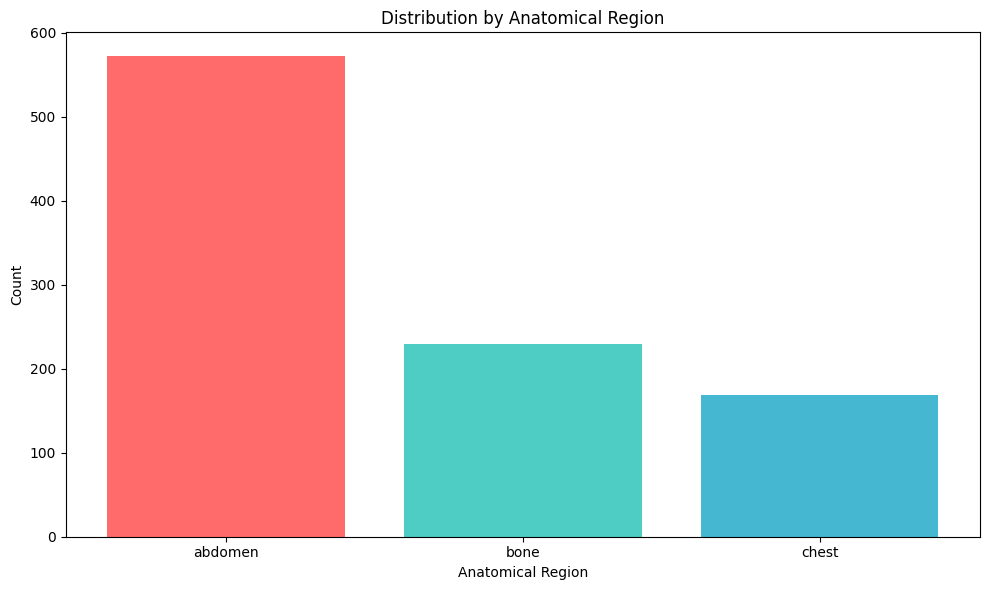


Region distribution:
  abdomen: 572 (58.9%)
  bone: 230 (23.7%)
  chest: 169 (17.4%)


In [5]:
# Group by anatomical region
region_counts = {}
for cls_idx in unique:
    organ_name = ORGAN_CLASSES[cls_idx]
    region = ORGAN_TO_REGION[organ_name]
    if region not in region_counts:
        region_counts[region] = 0
    # Find count for this class
    count = counts[np.where(unique == cls_idx)[0][0]]
    region_counts[region] += count

# Plot region distribution
plt.figure(figsize=(10, 6))
regions = list(region_counts.keys())
region_values = list(region_counts.values())

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
plt.bar(regions, region_values, color=colors)
plt.xlabel('Anatomical Region')
plt.ylabel('Count')
plt.title('Distribution by Anatomical Region')
plt.tight_layout()
plt.show()

print("\nRegion distribution:")
for region, count in region_counts.items():
    print(f"  {region}: {count} ({count/len(all_labels)*100:.1f}%)")

In [6]:
# Compute image statistics
sample_images, _ = next(iter(train_loader))

print("Image statistics:")
print(f"  Shape: {sample_images.shape}")
print(f"  Min value: {sample_images.min():.4f}")
print(f"  Max value: {sample_images.max():.4f}")
print(f"  Mean: {sample_images.mean():.4f}")
print(f"  Std: {sample_images.std():.4f}")
print(f"  Data type: {sample_images.dtype}")

Image statistics:
  Shape: torch.Size([32, 1, 28, 28, 28])
  Min value: 0.0000
  Max value: 1.0000
  Mean: 0.4931
  Std: 0.2734
  Data type: torch.float64


In [7]:
# Load other region-specific datasets
datasets_info = {
    'nodule': ('chest', NoduleMNIST3D),
    'adrenal': ('abdomen', AdrenalMNIST3D),
    'vessel': ('brain', VesselMNIST3D),
}

print("Additional MedMNIST3D Datasets:\n")
for dataset_name, (region, dataset_class) in datasets_info.items():
    dataset = dataset_class(split='train', download=True)
    print(f"{dataset_name.upper()} ({region}):")
    print(f"  Samples: {len(dataset)}")
    print(f"  Classes: {len(np.unique(dataset.labels))}")
    print(f"  Image shape: {dataset[0][0].shape}\n")

Additional MedMNIST3D Datasets:



Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
NODULE (chest):
  Samples: 1158
  Classes: 2
  Image shape: (1, 28, 28, 28)

Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
ADRENAL (abdomen):
  Samples: 1188
  Classes: 2
  Image shape: (1, 28, 28, 28)

Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
VESSEL (brain):
  Samples: 1335
  Classes: 2
  Image shape: (1, 28, 28, 28)

